<a href="https://colab.research.google.com/github/Gal712/project/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.io.json import json_normalize
import urllib.request
import json
from tqdm.notebook import tqdm as tqdm
import codecs
import time
from IPython.display import display
import matplotlib.pyplot as plt
from google.colab import files
import io
import numpy as np
import itertools
import six


In [ ]:
base_url = "https://sys.archives.gov.il/api/solr?fq[]=lang_code_s:he&fq[]=product_id_i:"
addURL = "https://storage.archives.gov.il/Archives/"
base_attachment_url = "https://www.archives.gov.il/"
product_extra_meta_data_url = "https://storage.archives.gov.il/Archives/{0}/Files/{1}/FILE-{2}.jsn"
product_data_url = "https://sys.archives.gov.il/api/solr?rows=1&fq[]=product_code_s:{0}&fq[]=lang_code_s:he"

In [ ]:
download_metadata_dir = "C:/Users/Adi/Desktop/Yael/Project/MetaDataDir/"
download_extra_metadata_dir = "C:/Users/Adi/Desktop/Yael/Project/ExtraMetaDataDir/"
download_attachment_dir = "C:/Users/Adi/Desktop/Yael/Project/AttachmentDir/"

In [ ]:
start_year_to_filter = 1947
end_year_to_filter = 1959

In [ ]:
def read_na_jsons(start_at, do_it_for):
    df_product_initial_metadata = pd.DataFrame()
    df_product_extra_metadata = pd.DataFrame()
    df_product_data = pd.DataFrame()

    for i in range(start_at, start_at + do_it_for):
        url = base_url + str(i)
        try:
            initial_product_meta_data = read_meta_data(url)
            start_year = int(initial_product_meta_data[0]["objDate_datingPeriodStartYear_t"])
            
            if((start_year > start_year_to_filter) & (start_year < end_year_to_filter)):
                product_meta_data_file_name = initial_product_meta_data[0]["objDesc_objectName_t"]
                load_data_into_file(initial_product_meta_data, product_meta_data_file_name + ".json")
                df_product_initial_metadata = add_json_to_data_frame(df_product_initial_metadata, initial_product_meta_data)

                df_product_extra_metadata = fetch_and_save_extra_metadata(df_product_extra_metadata, initial_product_meta_data,
                                                                       product_meta_data_file_name)
                product_data = read_product_data(initial_product_meta_data[0]["product_code_t"], product_data_url)
                df_product_data = add_json_to_data_frame(df_product_data, product_data)
                load_attachments(initial_product_meta_data[0], product_meta_data_file_name)
        except:
            continue
    return df_product_data, df_product_initial_metadata, df_product_extra_metadata

In [ ]:
def read_product_data(product_code, product_data_url):
  product_data_url = product_data_url.format(product_code)
  return read_meta_data(product_data_url)

In [ ]:
def fetch_and_save_extra_metadata(df_product_extra_metadata, initial_product_meta_data, product_meta_data_file_name):
    try:
        sku = initial_product_meta_data[0]["sku"]
        objHier_archiveId_t = initial_product_meta_data[0]["objHier_archiveId_t"]
        extra_product_metadata_url = product_extra_meta_data_url.format(objHier_archiveId_t, sku, sku)
        extra_product_meta_data = read_extra_data_json(extra_product_metadata_url, product_meta_data_file_name + ".json")
        extra_product_meta_data = pd.json_normalize(extra_product_meta_data)
        df_product_extra_metadata = add_json_to_data_frame(df_product_extra_metadata, extra_product_meta_data)
        return df_product_extra_metadata
    except:
        return df_product_extra_metadata

In [ ]:
def read_extra_data_json(url, file_name):
    try:
        dir, headers = urllib.request.urlretrieve(url, download_extra_metadata_dir + file_name)
        jfile = open(dir, 'r', encoding='utf8')
        metadata = json.loads(jfile.read())
        jfile.close
        return metadata
    except (Exception):
        raise Exception("Could not read data from the given url")

generic function to read json data into an object from a give url

In [ ]:
def read_meta_data(url):
    try:
        data = urllib.request.urlopen(url)
        if is_valid_data(data):
            metadata = json.loads(data.read())
            docs_data = metadata["response"]["docs"]
            return docs_data
    except:
        raise Exception("Could not open url")

load the meta data as a json file into external/local location

In [ ]:
def load_data_into_file(data_to_load, file_name):
    try:
        with open(download_metadata_dir + file_name, 'w', encoding='utf8') as jfile:
            jfile.write(json.dumps(data_to_load, indent=4, ensure_ascii=False))
            jfile.close()
    except:
        pass

load files that we've retrieved from the given url into external/local location

In [ ]:
def load_attachments(product_data, file_name):
    try:
        file_extension = "." + product_data["objHier_attachment_attachmentType_s"]
        url = base_attachment_url + product_data["attachment_url_s"]
        urllib.request.urlretrieve(url, download_attachment_dir + file_name + file_extension)
    except:
        raise Exception(
            "Could not load the wanted attachment")

In [ ]:
def is_valid_data(data):
    return data.getcode() != 404

add an entry in the data frame for the givan data

In [ ]:
def add_json_to_data_frame(df, data):
    if df.empty:
        df = pd.DataFrame(data)
    else:
        new_df = pd.DataFrame(data)
        df = df.append(new_df)
    return df

load files from a local folder into data frame

In [ ]:
def read_files_from_local_folder(dir, dataframe, is_extra_metadata):
    file_paths = os.listdir(dir)
    for path in file_paths:
        jfile = open(dir, 'r', encoding='utf8')
        metadata = json.loads(jfile.read())
        jfile.close
        if is_extra_metadata:
          metadata = pd.json_normalize(extra_product_meta_data)
        dataftame = add_json_to_data_frame(dataframe, metadata)
    return dataframe


In [ ]:
 df1, df2, df3 = read_na_jsons(1008796, 10)

In [ ]:
uploaded_df1 = files.upload()
uploaded_df2 = files.upload()
uploaded_df3 = files.upload()

Saving extraMetaData.csv to extraMetaData.csv


Saving Data.csv to Data.csv


create csv file out of every data frame

In [ ]:
df_initial_data = pd.read_csv(io.BytesIO(uploaded_df1['metaData.csv']))
df_extra_meta_data = pd.read_csv(io.BytesIO(uploaded_df2['extraMetaData.csv']))
df_product_data = pd.read_csv(io.BytesIO(uploaded_df3['Data.csv']))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,61,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,objectDating,alternateReference,contentEntity,generalValue,objectHierarchy.objectType,objectHierarchy.objectTypeDesc,objectHierarchy.objectId,objectHierarchy.objectReference,objectHierarchy.archiveId,objectHierarchy.archiveName,objectHierarchy.isFictiveItem,objectHierarchy.isDeleted,objectHierarchy.collections,objectHierarchy.noAttachment,objectHierarchy.parentObjectId,objectHierarchy.childrenCount,objectHierarchy.pageCount,objectHierarchy.hierarchyPath,objectHierarchy.children,objectHierarchy.attachment,objectDescription.objectName,objectDescription.objectDesc.displayValue,objectDescription.objectDesc.mlValue,objectDescription.objectThumbs.l_Wide_Url,objectDescription.objectThumbs.s_Wide_Url,objectDescription.objectThumbs.m_Orgin_Url,objectAttributes.archiveEditDate,objectAttributes.materialType,objectAttributes.datingGeneralDesc,objectAttributes.mediaType,objectAttributes.mediaTypeOrig,objectAttributes.isGsaFeedEnabled,additionalAttributes.objectName,additionalAttributes.orgTree,additionalAttributes.type,additionalAttributes.siduriMeichal,additionalAttributes.statusChasifa,additionalAttributes.ichidatIchsun,additionalAttributes.tikOldNumber,additionalAttributes.matsa,additionalAttributes.taarichMiuiadHashifa,additionalAttributes.taarichYetzira,additionalAttributes.mezaheh,additionalAttributes.meichalNumber,additionalAttributes.rimonObjectName,additionalAttributes.mezaheSimulMekori,objectIncidents,additionalAttributes.zmanBedakot,additionalAttributes.sugKaletetVideo,additionalAttributes.makom,additionalAttributes.weblinkHeb,additionalAttributes.rochavBesam,additionalAttributes.kne_mida,additionalAttributes.orechOrGovaBesam,additionalAttributes.sugMapa,additionalAttributes.tseva,additionalAttributes.safa,additionalAttributes.sahacTatslumim,additionalAttributes.sugTatslum,objectAttributes.copyrightConditions,additionalAttributes.taarichTatslum,additionalAttributes.sugKaletet,additionalAttributes.mekomTatslum,additionalAttributes.taarichHafaka
0,0,"[{'datingPeriodStart': '1951-01-01', 'datingPeriodEnd': '1951-12-31'}]","[{'objectId': '', 'relationType': {'displayValue': 'סימול מקורי', 'mlValue': [{'value': 'סימול מקורי', 'invariant': False}]}}]","[{'entityName': {'displayValue': 'המועצה למחקר מדעי ותעשייתי-ממשלת ארץ ישראל', 'mlValue': [{'value': 'המועצה למחקר מדעי ותעשייתי-ממשלת ארץ ישראל', 'invariant': False}]}, 'entityRole': {'displayValue': 'גופים', 'mlValue': [{'value': 'גופים', 'invariant': False}]}, 'entityId': '0b0717068002263d', 'entityUrl': 'Topics/TOPIC-0b0717068002263d.jsn'}]",NaN,FILE,תיק,0b07170680bc4a47,ISA-MandatoryOrganizations-MandateResearch-000nznd,0b0717068002263d,המועצה למחקר מדעי ותעשייתי-ממשלת ארץ ישראל,False,False,NaN,0,0b07170680359293,1,1.0,"[{'objectType': 'FILE', 'objectId': '0b07170680bc4a47', 'objectReference': 'ISA-MandatoryOrganizations-MandateResearch-000nznd', 'objectName': [{'displayValue': '( Index of International Civil Aviation Organization (I.C.A.O', 'mlValue': [{'value': '( Index of International Civil Aviation Organization (I.C.A.O', 'invariant': False}]}], 'objectUrl': 'Archives/0b0717068002263d/Files/0b07170680bc4a47/FILE-0b07170680bc4a47.jsn', 'objectThumbs': {'l_Wide_Url': 'NA', 's_Wide_Url': 'NA', 'm_Orgin_Url': 'NA'}, 'mediaType': [{'displayValue': 'מסמך', 'mlValue': [{'value': 'מסמך', 'invariant': False}]}]}, {'objectType': 'HAFKADA', 'objectId': '0b07170680359293', 'objectName': [{'displayValue': '0002epr', 'mlValue': [{'value': '0002epr', 'invariant': False}]}], 'objectUrl': 'Archives/0b0717068002263d/Topics/TOPIC-0b07170680359293.jsn', 'objectThumbs': {'l_Wide_Url': 'NA', 's_Wide_Url': 'NA', 'm_Orgin_Url': 'NA'}}]","[{'objectType': 'ITEM', 'objectId': '090717068416dfa0', 'objectName': [{'displayValue': '000nznd', 'mlValue': [{'value': '000nznd', 'invariant': False}]}], 'objectUrl': 'Archives/0b0717068002263d/Files/0b07170680bc4a47/ITEM-090717068416dfa0.jsn', 'objectThumbs': {'l_Wide_Url': 'NA', 's_Wide_Url': 'NA', 'm_Orgin_Url': 'NA'}, 'mediaType': [{'displayValue': 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (177,178,179,181,184,185,186,189,190,191,192,193,194) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,product_id_i,type_i,lang_code_s,name,sku,GroupFamilyName_s,modification_timestamp_tdt,modification_timestamp_s,group_id_i,product_code_t,FamilyName_t,objHier_objectType_t,objHier_isFictiveItem_t,objHier_isDeleted_t,objDesc_objectName_t,objDesc_objectName_tphon,objDesc_objectName_e_t,objDesc_objectDesc_t,objDesc_objectDesc_tar,objDesc_objectDesc_tfr,objDesc_objectDesc_e_t,objAttr_isGsaFeedEnabled_t,objDate_datingPeriodStart_t,objDate_datingPeriodStartYear_t,objDate_datingPeriodEnd_t,objDate_datingPeriodEndYear_t,objHier_archiveId_t,objHier_archiveName_t,objHier_archiveName_e_t,objHier_parentObjectId_t,objAttr_archiveEditDate_t,objAttr_materialType_t,objAttr_mediaType_t,objAttr_mediaTypeOrig_t,addAttr_objectName_t,addAttr_orgTree_t,addAttr_orgTree_e_t,addAttr_type_t,objHier_objectReference_t,...,attachment_content_tar,attachment_content_tfr,attachment_content_e_t,group_id_is,objectDatingYear_ss,objDesc_objectDesc_short_s,sig_media_type_s,sig_media_type_ss,attachment_url_s,objHier_attachment_attachmentType_s,objectDatingMonths_ss,objectDatingMonths_dts,_version_,addAttr_makom_t,addAttr_makom_s,addAttr_makom_ss,enrichment_ss,enrichment_1_ss,enrichment_2_ss,subject_ss,place_ss,person_ss,objHier_collections_t,objHier_collections_s,objHier_collections_ss,event_ss,objHier_attachment_attachmentId_t,objHier_attachment_document_t,objHier_attachment_page_t,objHier_attachment_isActualFile_t,objHier_attachment_attachmentSource_t,objHier_attachment_attachmentId_s,objHier_attachment_document_s,objHier_attachment_page_s,objHier_attachment_isActualFile_s,objHier_attachment_attachmentSource_s,objHier_attachment_attachmentId_ss,objHier_attachment_document_ss,objHier_attachment_page_ss,objHier_attachment_isActualFile_ss
0,0,1008802,1,en,File,0b07170680b64496,13325-0b07170680b64496,2019-12-22T20:16:52Z,2019-12-22 20:16:52,13325,0b07170680b64496,0b07170680b64496,FILE,False,False,בקורת משרד הדאר - השירות הבולאי בקורת מלאי הבולים כולל ארכיון הבולים של השרות הבולאי ובולי U.P.U (אגוד הדואר העולמי),בקורת משרד הדאר - השירות הבולאי בקורת מלאי הבולים כולל ארכיון הבולים של השרות הבולאי ובולי U.P.U (אגוד הדואר העולמי),בקורת משרד הדאר - השירות הבולאי בקורת מלאי הבולים כולל ארכיון הבולים של השרות הבולאי ובולי U.P.U (אגוד הדואר העולמי),"התכתבות, פרוטוקול ונתונים בנוגע למשלוחים שהוחזרו, בקורת בארכיון השרות ועוד","התכתבות, פרוטוקול ונתונים בנוגע למשלוחים שהוחזרו, בקורת בארכיון השרות ועוד","התכתבות, פרוטוקול ונתונים בנוגע למשלוחים שהוחזרו, בקורת בארכיון השרות ועוד","התכתבות, פרוטוקול ונתונים בנוגע למשלוחים שהוחזרו, בקורת בארכיון השרות ועוד",True,01/12/1957,1957,30/06/1959,1959,0b0717068001c53e,חטיבת משרדי ממשלה ומוסדות המדינה,חטיבת משרדי ממשלה ומוסדות המדינה,0b07170680358f07,2019-12-18,תיק מסמכים,מסמך,תיק מסמכים,חטיבת משרדי ממשלה ומוסדות המדינה,מבקר המדינה ונציב תלונות הציבור/חטיבת משרדי ממשלה ומוסדות המדינה,מבקר המדינה ונציב תלונות הציבור/חטיבת משרדי ממשלה ומוסדות המדינה,תיק מסמכים,ISA-comptroller-StateInstitutions-000mxgx,...,NaN,NaN,NaN,[1],"['1957', '1959']","התכתבות, פרוטוקול ונתונים בנוגע למשלוחים שהוחזרו, בקורת בארכיון השרות ועוד",תיק,['תיק'],Archives/0b0717068001c53e/Files/0b07170680b64496/00071706.81.D6.1E.BB.pdf,pdf,"['12/1957', '01/1958', '02/1958', '03/1958', '04/1958', '05/1958', '06/1958', '07/1958', '08/1958', '09/1958', '10/1958', '11/1958', '12/1958', '01/1959', '02/1959', '03/1959', '04/1959', '05/1959', '06/1959']","['1957-12-01T00:00:00Z', '1958-01-01T00:00:00Z', '1958-02-01T00:00:00Z', '1958-03-01T00:00:00Z', '1958-04-01T00:00:00Z', '1958-05-01T00:00:00Z', '1958-06-01T00:00:00Z', '1958-07-01T00:00:00Z', '1958-08-01T00:00:00Z', '1958-09-01T00:00:00Z', '1958-10-01T00:00:00Z', '1958-11-01T00:00:00Z', '1958-12-01T00:00:00Z', '1959-01-01T00:00:00Z', '1959-02-01T00:00:00Z', '1959-03-01T00:00:00Z', '1959-04-01T00:00:00Z', '1959-05-01T00:00:00Z', '1959-06-01T00:00:00Z']",1683600754587205632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1008832,1,en,File,0b07170680b0c8ba,13325

join the data frames into one data frame.
create a csv file out of the merged data frame in order to upload it to WIX

In [ ]:
final_merged_df = pd.merge(df_product_data, df_extra_meta_data, left_on= 'sku', right_on='objectHierarchy.objectId', how='inner')
csvfile = final_merged_df.to_csv("final.csv")

In [ ]:
def replace_nans(value) :
  return [v if isinstance(v,str) else "אחר" for v in value]

In [ ]:
def reshape_text(value):
  return [v[::-1] for v in value]

In [ ]:
searched_keywords = ["מלחמה", "עלייה", "בן גוריון", "הגירה", "גרמניה", "שואה", "ילדי תימן", "עצמאות", "צנע", "ירושלים", "הסתדרות", "שלום", "פליטים", "מלחמת"]

In [ ]:
def filter_description(object_descriptions, search_keywords):
  return list(filter(lambda description: does_keyword_exits_in_description(description), object_descriptions))

In [ ]:
def does_keyword_exits_in_description(description):
  str_description = str(description)
  for keyword in searched_keywords:
    if keyword in str_description:
      return True
  return False


In [ ]:
def number_of_files_match_keyword(files_description):
  num_of_apperances = []
  df = pd.DataFrame()
  for keyword in searched_keywords:
    num_of_keyword_appearences = 0
    for description in files_description:
      if keyword in str(description):
        num_of_keyword_appearences += 1
    num_of_apperances.append(num_of_keyword_appearences)
        
  return pd.DataFrame({'size': num_of_apperances}, index = reshape_text(searched_keywords))


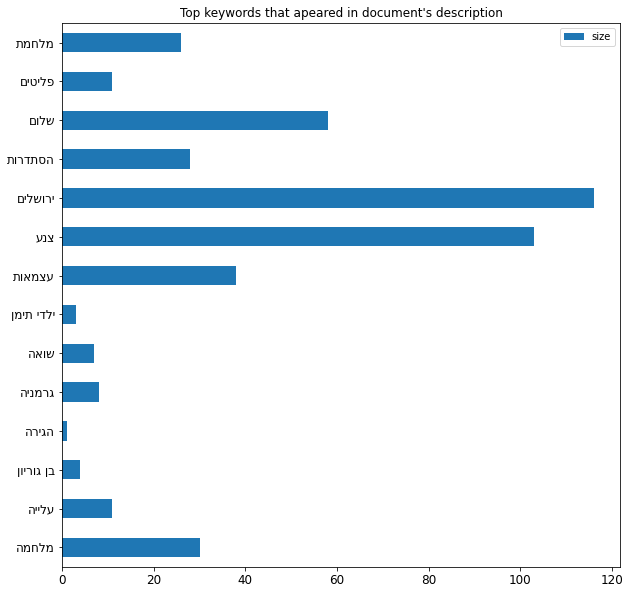

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
temp_df = number_of_files_match_keyword(final_merged_df.objDesc_objectDesc_t)
temp_df.plot.barh(ax = ax, fontsize = 12, title = "Top keywords that apeared in document's description")

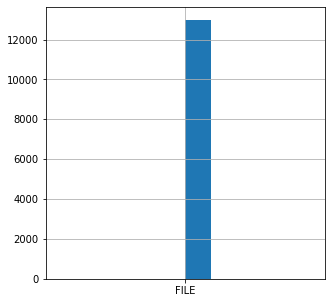

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
final_merged_df.objHier_objectType_t.hist(ax = ax)

Text(0.5, 1.0, 'דועיתה רוקמ')

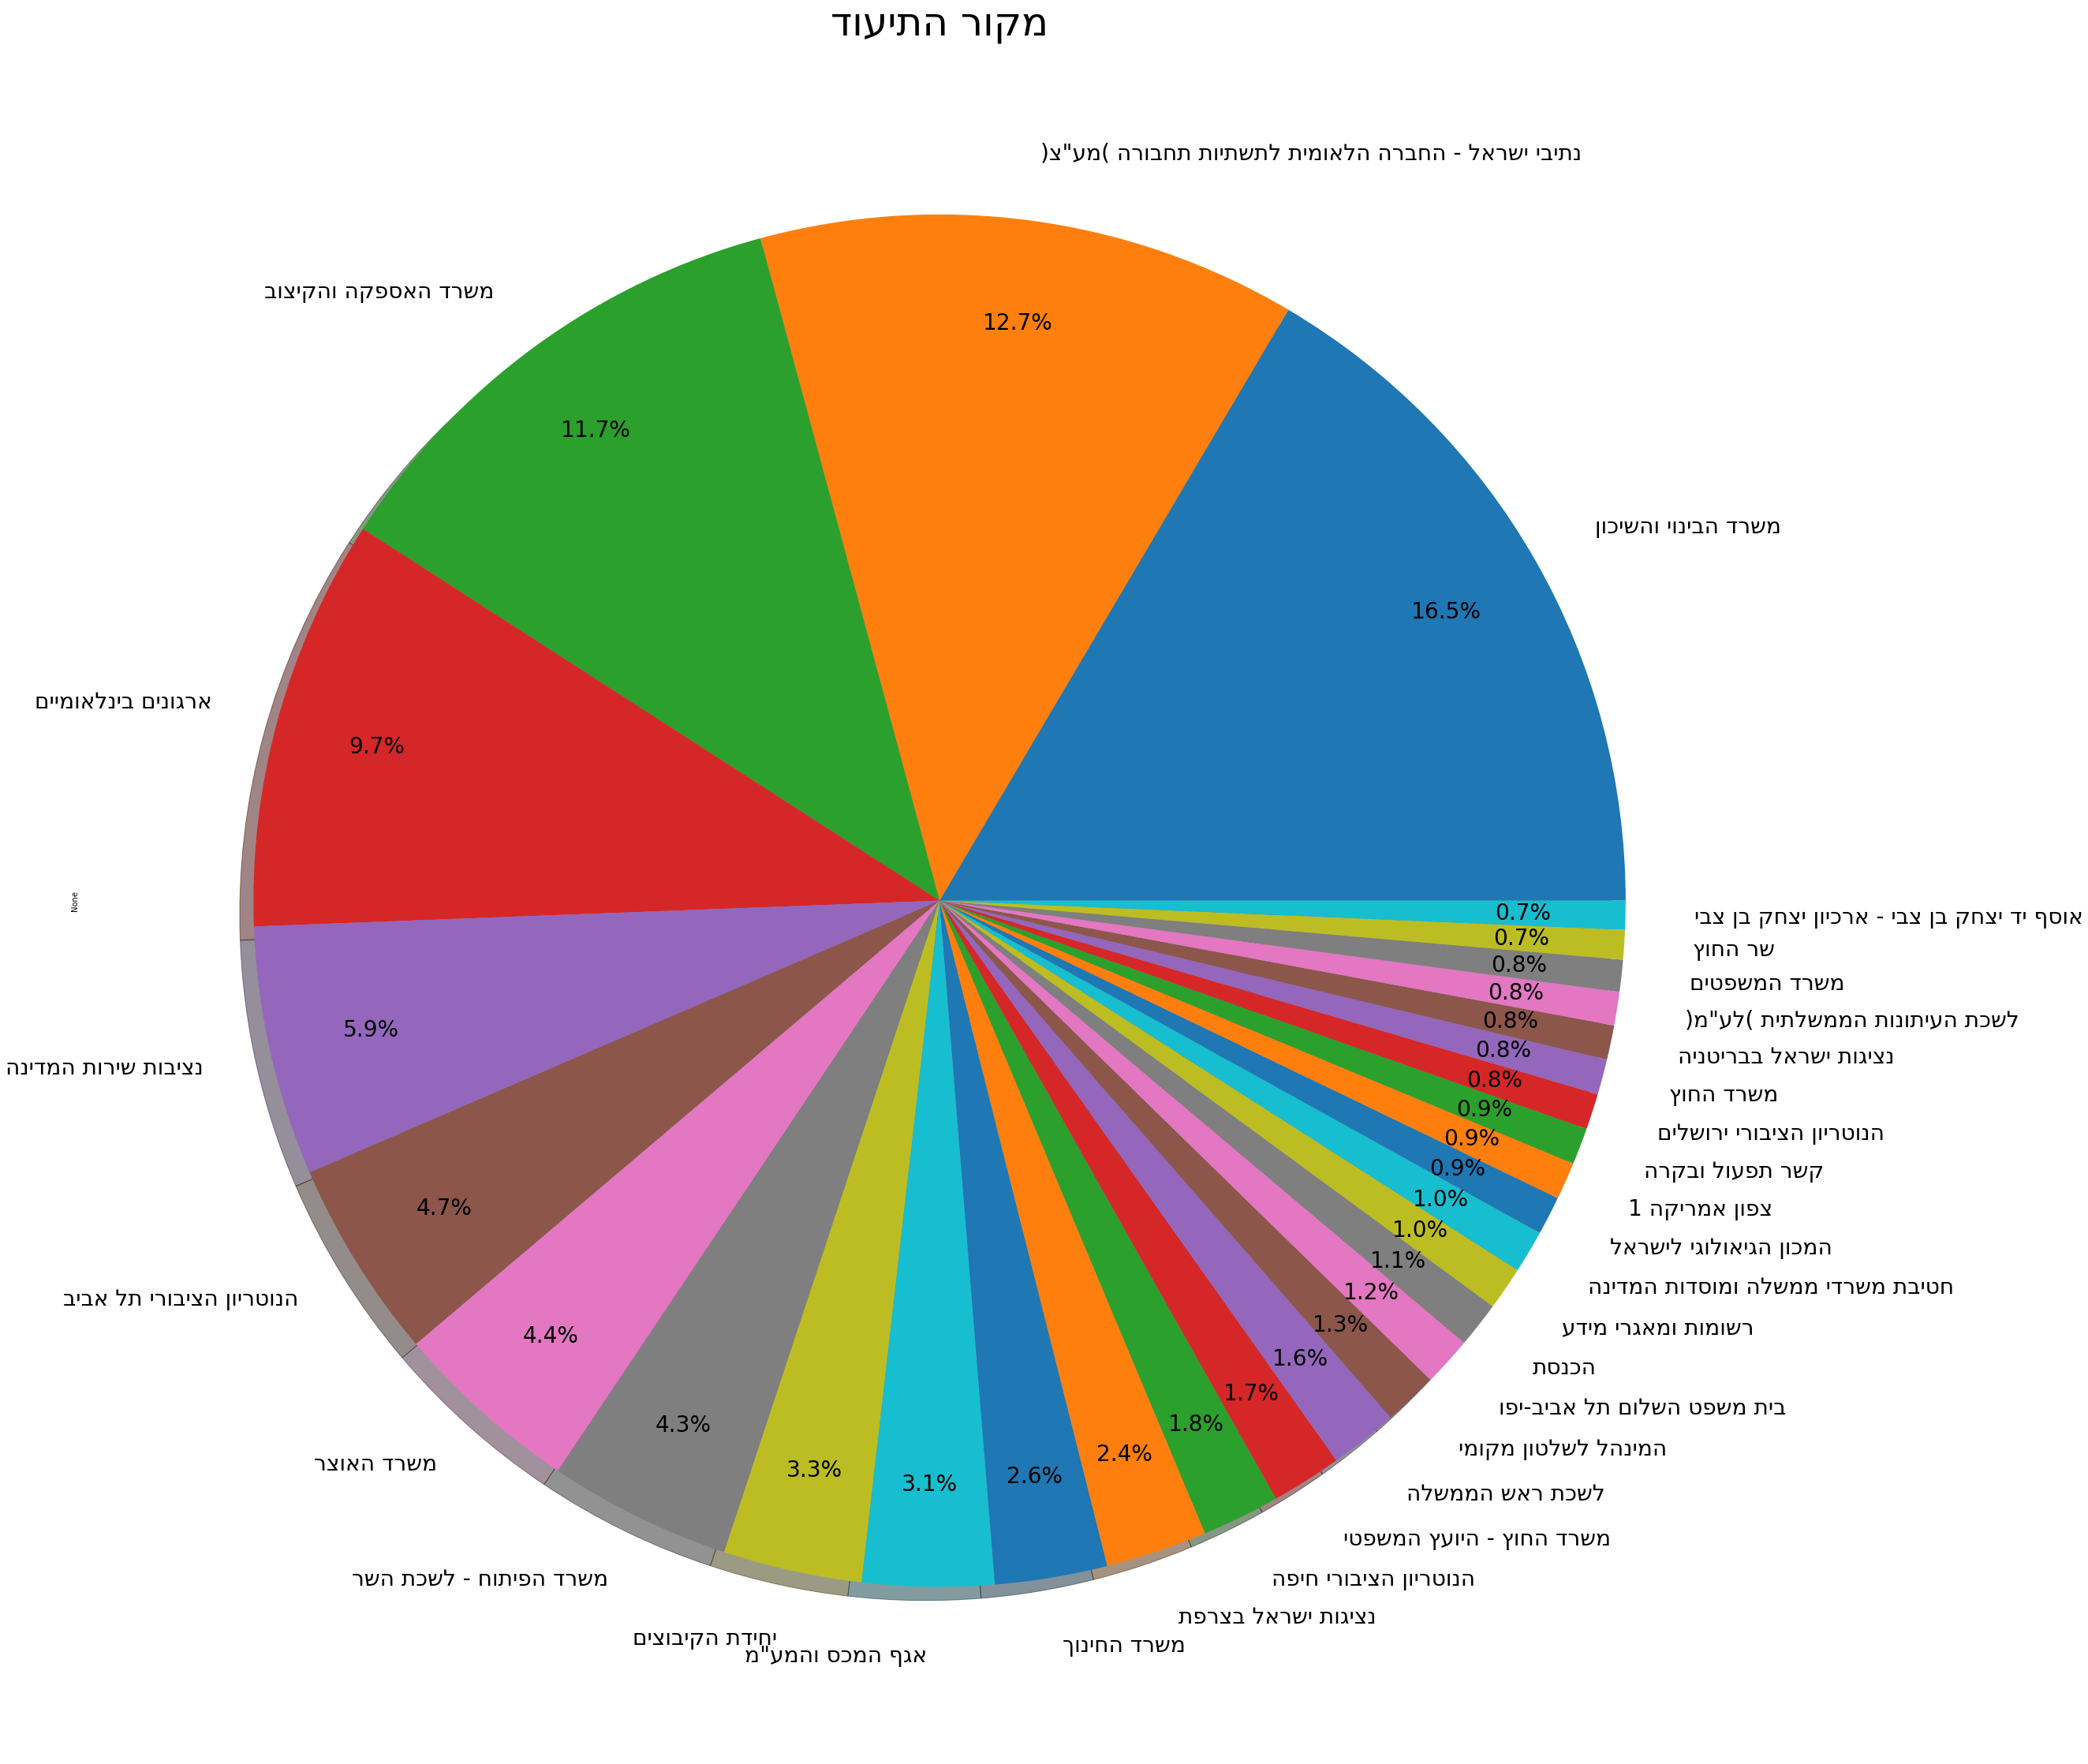

In [ ]:
new_df = final_merged_df 
new_df.objHier_archiveName_t = reshape_text(replace_nans(final_merged_df.objHier_archiveName_t))
df_origin = final_merged_df.groupby("objHier_archiveName_t").size().nlargest(30)
df_origin.plot.pie(y = (new_df.objHier_archiveName_t),shadow = True,figsize=(45,40), autopct='%1.1f%%', title="דועיתה רוקמ", fontsize=28, pctdistance=0.85)
plt.title("דועיתה רוקמ", fontsize=50)


In [ ]:
temp_df = final_merged_df.groupby("objAttr_materialType_t").size()
temp_df.to_csv("material_type.csv")
display(temp_df)


objAttr_materialType_t
הקלטת קול                    3
מוצג                         1
מפה                         22
ספר יסוד של בתי המשפט       76
סרט                         71
תיק מסמכים               12756
תצלום                       52
dtype: int64

Text(0.5, 1.0, 'Top institutes that documented files')

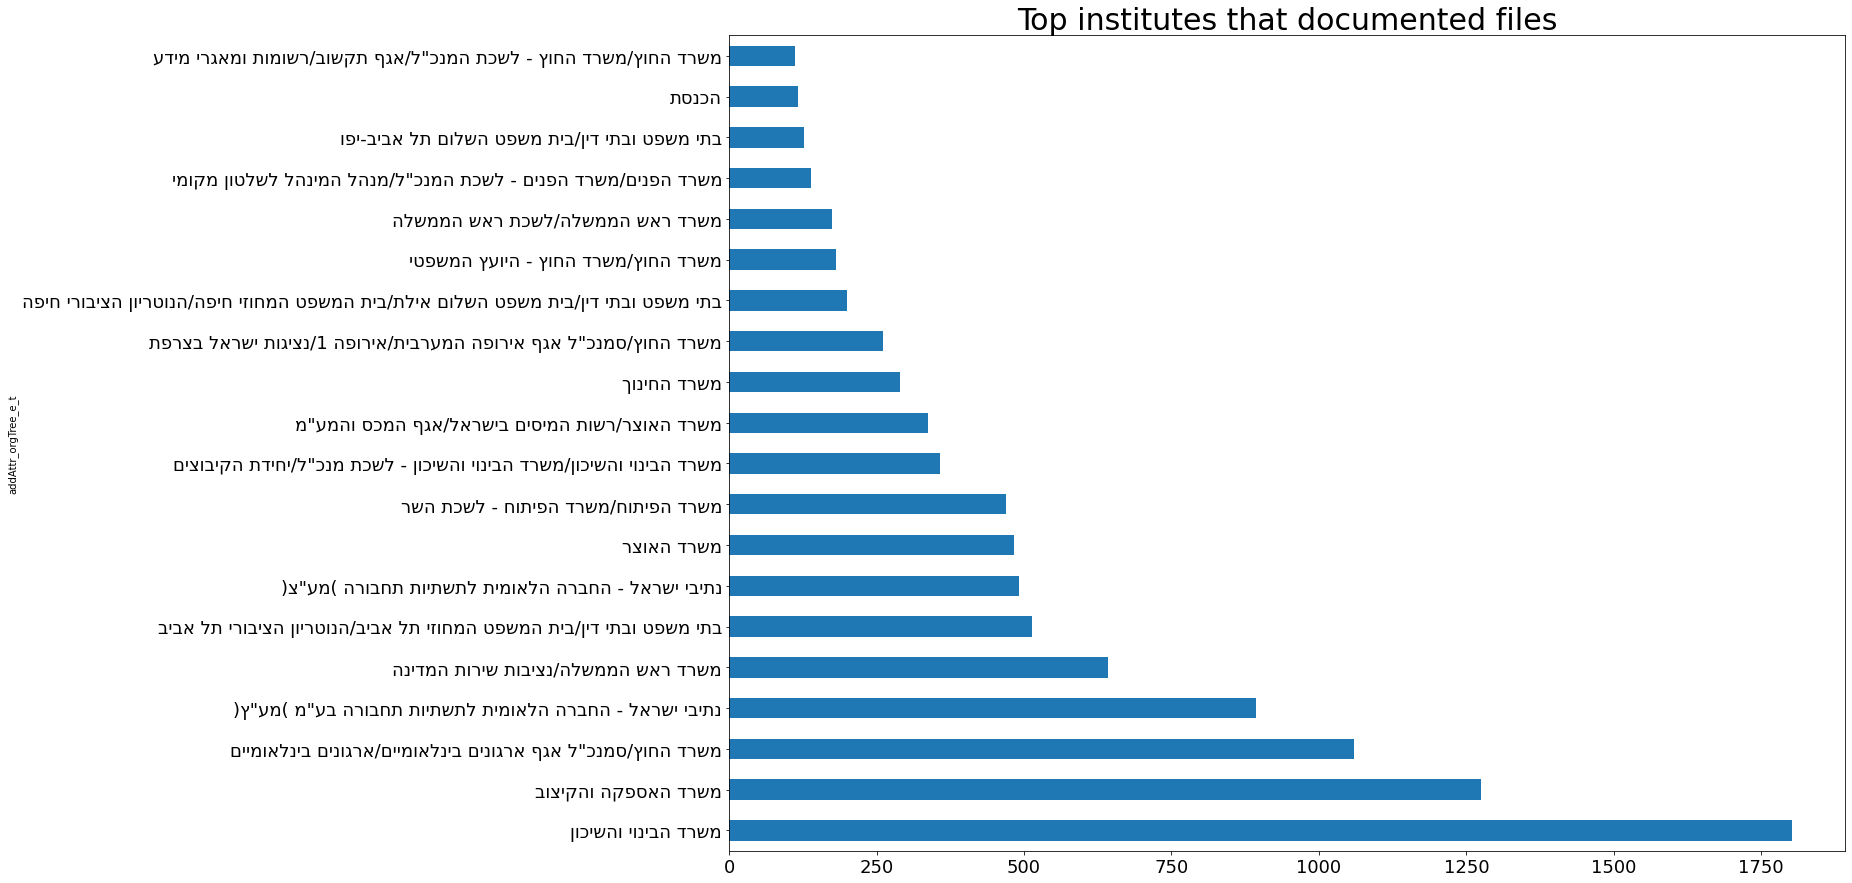

In [ ]:
fig = plt.figure(figsize = (20,15)) 
ax = fig.gca() 
temp_df = final_merged_df 
temp_df.addAttr_orgTree_e_t = reshape_text(final_merged_df.addAttr_orgTree_e_t) 
test = temp_df.groupby("addAttr_orgTree_e_t").size() 
temp_df.groupby("addAttr_orgTree_e_t").size().nlargest(20).plot(kind="barh", fontsize=18, title= "Top institutes that documented files" ) 
plt.title("Top institutes that documented files", fontsize=30)

In [ ]:
def prepare_statusea_pie_chart(df):
  temp_df = df 
  temp_df.addAttr_statusChasifa_t = reshape_text(replace_nans(temp_df.addAttr_statusChasifa_t))
  df_statuses = temp_df.groupby("addAttr_statusChasifa_t").size()
  df_statuses.plot.pie(y = new_df.addAttr_statusChasifa_t ,shadow = True, fontsize=14,
  figsize=(15,10), autopct='%1.1f%%' )
  plt.title("הפישח סוטטס", fontsize=20)
  

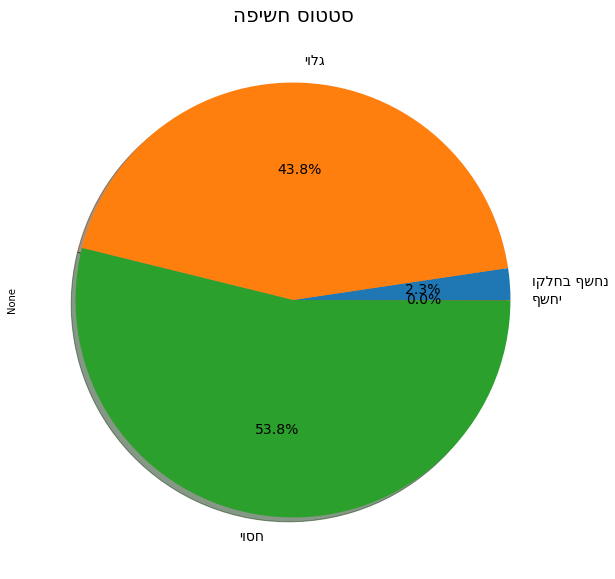

In [ ]:
prepare_statusea_pie_chart(final_merged_df)

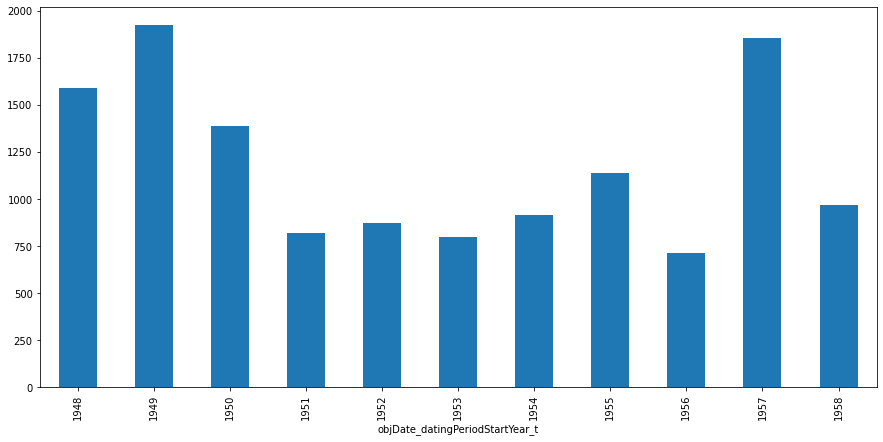

In [ ]:
fig = plt.figure(figsize = (15,7))
ax = fig.gca()
final_merged_df.groupby("objDate_datingPeriodStartYear_t").size().plot(kind="bar")

In [ ]:
def filter_nans(values):
  return list(filter(lambda v: pd.isnull(v) == False, values))

In [ ]:
def flatten_to_strings(listOfLists):
    result = []
    for i in listOfLists:
        if isinstance(i, six.string_types):
            result.append(i)
        else:
            result.extend(flatten_to_strings(i))
    return result


In [ ]:
def get_persons_in_data_frame(person_ss):
    persons_list = []
    for p in person_ss:
      persons_list.append(eval(p))
    return persons_list

In [ ]:
def filter_duplicate_persons(list_of_persons):
  p_l_without_dups = []
  for person in list_of_persons:
    if not "(" in person:
      p_l_without_dups.append(person)
  return p_l_without_dups

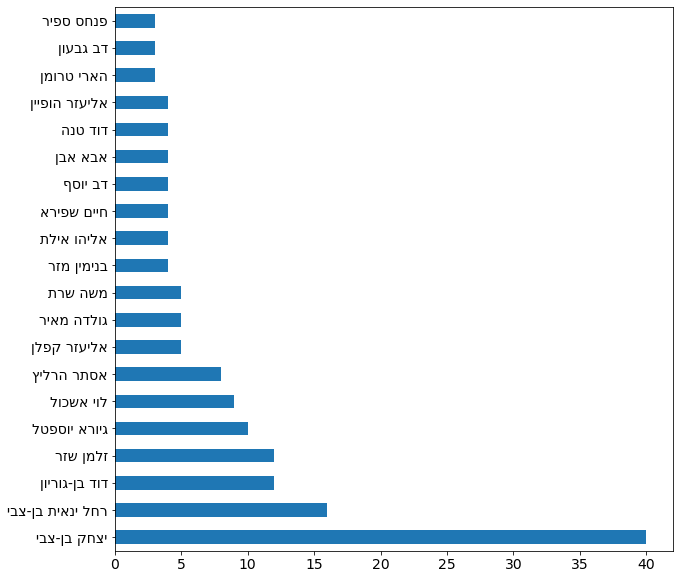

In [ ]:
persons_list = get_persons_in_data_frame(filter_nans(final_merged_df.person_ss))
flatten_persons_list = filter_duplicate_persons(flatten_to_strings(persons_list))
num_of_ap_per_person = []
persons_list = []
for person in flatten_persons_list:
  if not person in persons_list:
    num_of_ap_per_person.append(flatten_persons_list.count(person))
    persons_list.append(person)
personsDataFrame = pd.DataFrame({"num_of_appearences":num_of_ap_per_person}, index= reshape_text(persons_list))
personsDataFrame.num_of_appearences.nlargest(20).plot.barh(figsize=(10,10), fontsize= 14)


In [ ]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

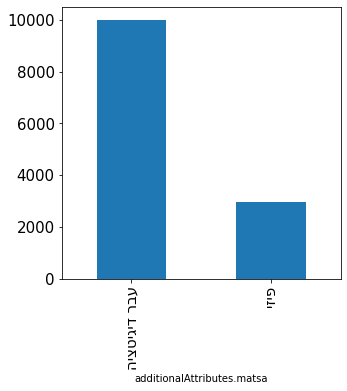

In [ ]:
matsa_loc = column_index(final_merged_df, ["additionalAttributes.matsa"])
new_df = final_merged_df
new_df.iloc[:,matsa_loc[0]] = reshape_text(final_merged_df.iloc[:,matsa_loc[0]])
new_df.groupby(new_df.iloc[:,matsa_loc[0]]).size().plot.bar(figsize=(5,5), fontsize=15)

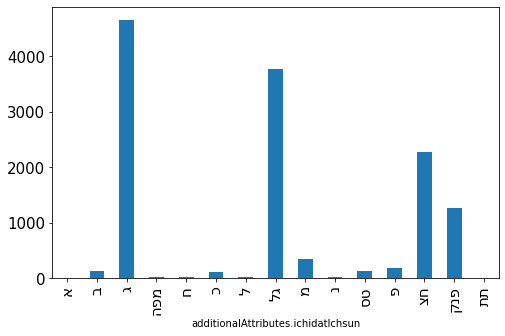

In [ ]:
ichsun_loc = column_index(final_merged_df, ["additionalAttributes.ichidatIchsun"])
new_df = final_merged_df
new_df.iloc[:,ichsun_loc[0]] = reshape_text(final_merged_df.iloc[:,ichsun_loc[0]])
new_df.groupby(new_df.iloc[:,ichsun_loc[0]]).size().plot.bar(figsize=(8,5), fontsize=15)